In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from counterfactuals.datasets import DigitsDataset
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.cf_methods import PUMAL
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    MultilayerPerceptron,
)
from counterfactuals.metrics import CFMetrics

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = DigitsDataset("../data/digits.csv")

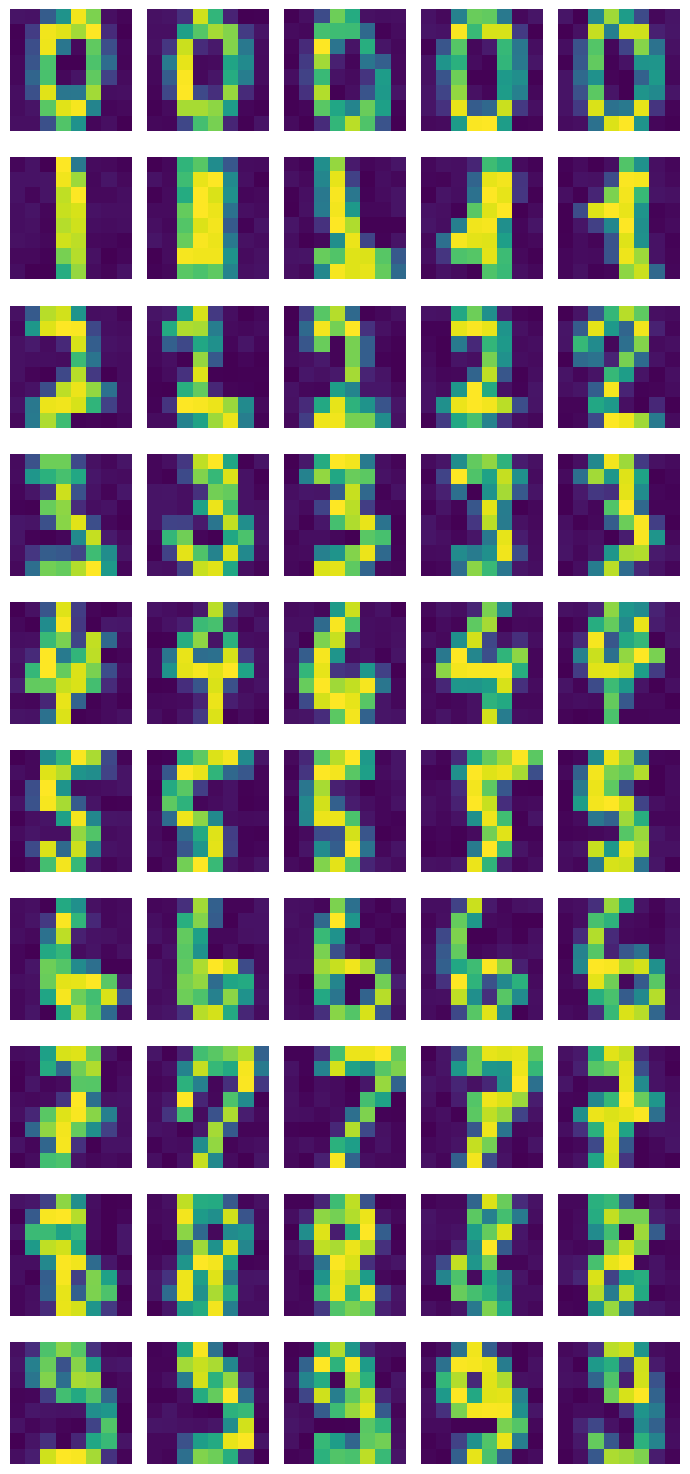

In [4]:
fig, axes = plt.subplots(10, 5, figsize=(7, 15))

for class_label in range(10):
    class_indices = np.where(np.argmax(dataset.y_train, axis=1) == class_label)[0]
    random_indices = np.random.choice(class_indices, 5, replace=False)

    for i, idx in enumerate(random_indices):
        ax = axes[class_label, i]
        samples = dataset.X_train[idx].reshape(8, 8)
        samples = DigitsDataset.inverse_transform(samples)
        ax.imshow(samples)
        ax.axis("off")
        if i == 0:
            ax.set_ylabel(f"Class {class_label}", rotation=0, labelpad=20, size="large")

plt.tight_layout()
plt.show()

In [8]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 10, device="mps")
# disc_model.to("mps")
# disc_model.fit(
#     dataset.train_dataloader(batch_size=128, shuffle=True, noise_lvl=0.003),
#     dataset.test_dataloader(batch_size=128, shuffle=False),
#     epochs=100,
#     patience=100,
#     lr=3e-4,
#     checkpoint_path="digits_disc_model.pt",
# )
disc_model.load("digits_disc_model.pt")
disc_model.to("cpu")
disc_model.eval()

/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_st

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (final_activation): Softmax(dim=1)
  (criterion): CrossEntropyLoss()
)

In [9]:
# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=256, shuffle=True),
#     dataset.test_dataloader(batch_size=256, shuffle=False),
#     epochs=5000,
#     patience=100,
#     checkpoint_path="disc_model.pt",
# )
# # disc_model.load("disc_model.pt")

In [10]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == np.argmax(dataset.y_test, axis=1)).mean())

Test accuracy: 0.9777580071174378


In [11]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=256,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=10,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
    device="cpu",
)
train_dataloader = dataset.train_dataloader(
    batch_size=128, shuffle=True, noise_lvl=0.003
)
# train_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)
test_dataloader = dataset.test_dataloader(batch_size=2048, shuffle=False)

# gen_model.fit(
#     train_dataloader,
#     test_dataloader,
#     learning_rate=1e-4,
#     patience=30,
#     num_epochs=500,
#     checkpoint_path="digits_gen_model1.pt",
# )
gen_model.load("digits_gen_model.pt")

/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf/maf.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.loa

In [12]:
# dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
# dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [13]:
input = torch.tensor(dataset.X_train, dtype=torch.float32)
labels = torch.tensor(dataset.y_train, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    output = -gen_model(input, labels).mean()
    print(output)


input = torch.tensor(dataset.X_test, dtype=torch.float32)
labels = torch.tensor(dataset.y_test, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    output = -gen_model(input, labels).mean()
    print(output)

tensor(90.9194)
tensor(101.9157)


/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_27795/1746027978.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  context_t = torch.tensor([np.eye(10)[context]]).view(-1, 10).float()


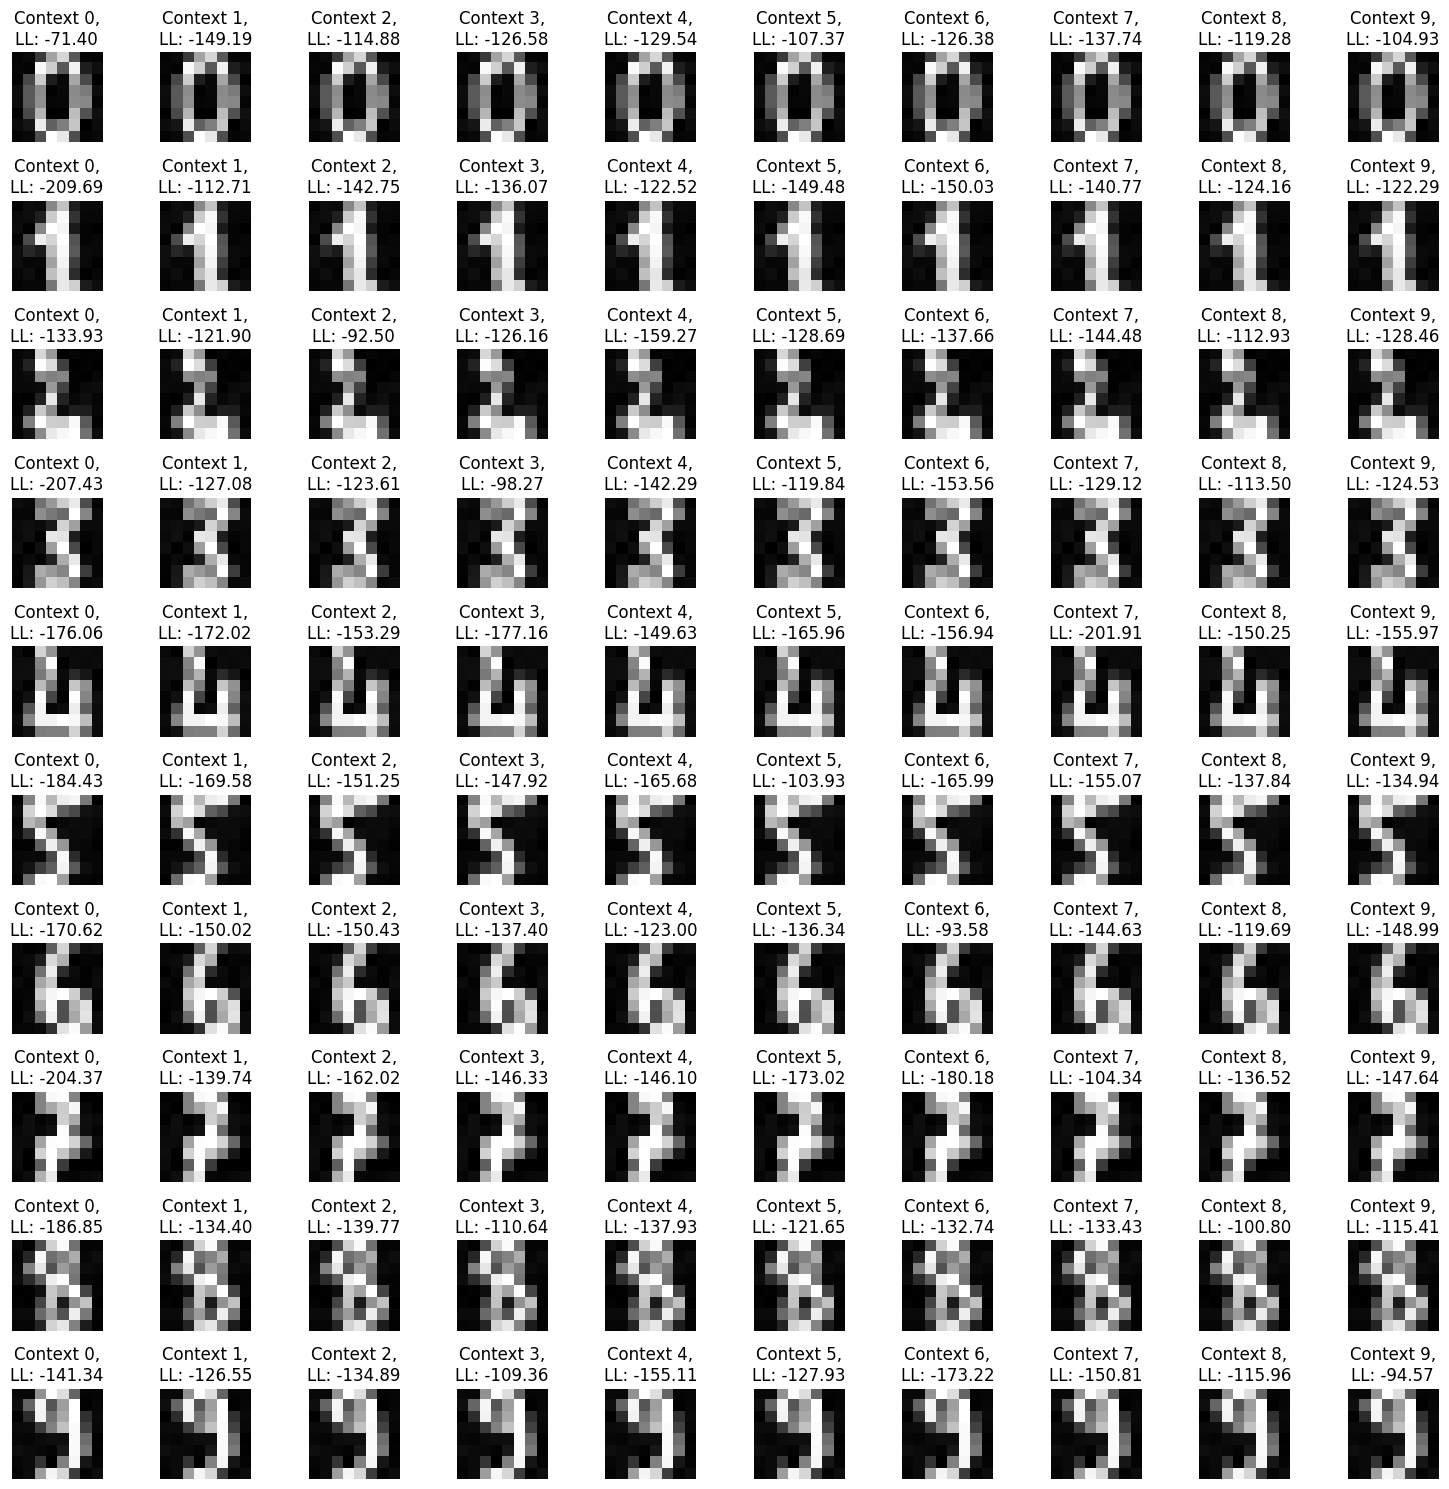

In [14]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i in range(10):
    for context in range(10):
        input = torch.tensor(
            dataset.X_test[np.argmax(dataset.y_test, axis=1) == i][0],
            dtype=torch.float32,
        )
        with torch.no_grad():
            context_t = torch.tensor([np.eye(10)[context]]).view(-1, 10).float()
            input = input.view(1, -1)
            gen_model.eval()
            output = gen_model(input, context_t).detach().numpy()
        ax = axes[i, context]
        ax.imshow(
            DigitsDataset.inverse_transform(input.numpy().reshape(8, 8)), cmap="gray"
        )
        ax.set_title(f"Context {context},\nLL: {output.item():.2f}")
        ax.axis("off")

plt.tight_layout()
plt.show()

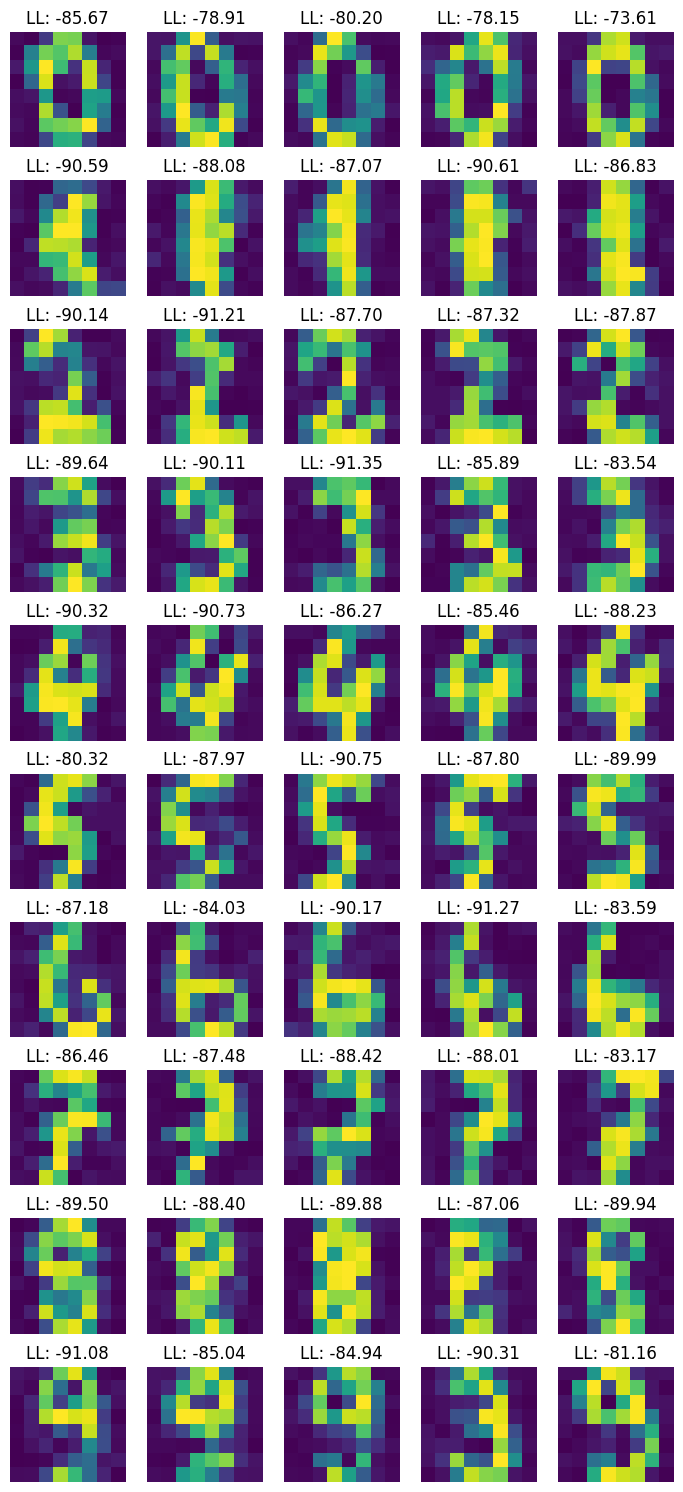

In [16]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.5,
)

fig, axes = plt.subplots(10, 5, figsize=(7, 15))

for class_label in range(10):
    context_t = torch.tensor([np.eye(10)[class_label]]).view(-1, 10).float()
    generated_images, ll = gen_model.sample_and_log_prob(100, context=context_t)
    high_prob_indices = (ll[0] > log_prob_threshold).nonzero(as_tuple=True)[0]
    selected_indices = np.random.choice(high_prob_indices, 5, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = axes[class_label, i]
        samples = generated_images[0][idx].view(8, 8).detach().numpy()
        samples = DigitsDataset.inverse_transform(samples)
        ax.imshow(samples)
        ax.set_title(f"LL: {ll[0][idx].item():.2f}")
        ax.axis("off")
        if i == 0:
            ax.set_ylabel(f"Class {class_label}", rotation=0, labelpad=20, size="large")

plt.tight_layout()
plt.show()

# 6 to 3 Transition

In [99]:
dataset = DigitsDataset("../data/digits.csv")
source_class = 6
target_class = 3
X_test_origin = dataset.X_test[np.argmax(dataset.y_test, axis=1) == source_class]
y_test_origin = dataset.y_test[np.argmax(dataset.y_test, axis=1) == source_class]

cf_method = PUMAL(
    X=X_test_origin,
    cf_method_type="GCE",
    K=3,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.01),
    not_actionable_features=None,
    neptune_run=None,
)

In [ ]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    target_class=target_class,
    epochs=20000,
    lr=0.01,
    patience=500,
    alpha_dist=1e-3,
    alpha_plaus=10**3,
    alpha_class=10**5,
    alpha_s=10**3,
    alpha_k=10**1,
    log_prob_threshold=log_prob_threshold,
)

loss: 0.0002, dist: 0.1182, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000:  12%|█▏        | 2448/20000 [00:28<03:25, 85.32it/s]             


In [101]:
Xs_cfs = Xs + delta().detach().numpy()

M, S, D = delta.get_matrices()
print(S.sum(axis=0))
values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

y_pred = disc_model.predict(Xs_cfs).detach().numpy().flatten()
# print("Test accuracy:", (y_pred == ys_target).mean())
print("Test accuracy:", (y_pred == np.argmax(ys_target, axis=1)).mean())

tensor([95., 17.,  0.], grad_fn=<SumBackward1>)
Correct: 112/112
2
Test accuracy: 1.0


In [102]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.01,
)

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 15.416539779325648,
 'proximity_continuous_manhattan': 118.19707890695307,
 'proximity_continuous_euclidean': 15.416539779325648,
 'proximity_continuous_mad': 121.30532584871564,
 'proximity_l2_jaccard': 15.416539779325648,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.0,
 'log_density_cf': -305.47787,
 'log_density_test': -98.95802,
 'lof_scores_cf': 1.4480202,
 'lof_scores_test': 1.0468404,
 'isolation_forest_scores_cf': 0.03861573007312751,
 'isolation_forest_scores_test': 0.07953767164660623}

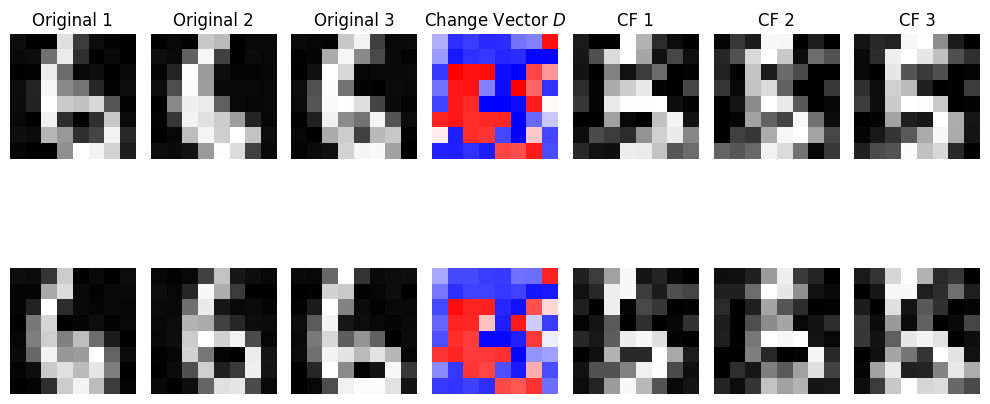

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming X_test_origin, Xs_cfs, D, and S are already defined
unique_groups = torch.unique(S.argmax(dim=1))
num_images = 3
fig, axes = plt.subplots(
    len(unique_groups), 2 * num_images + 1, figsize=(10, 6)
)  # 3 original, 1 D, 3 counterfactual

for group_i, group in enumerate(unique_groups):
    # Get indices for the current group
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    np.random.seed(2)
    selected_indices = np.random.choice(group_indices, num_images, replace=False)
    # num_images = min(3, len(group_indices))  # Limit to 3 images per group
    # selected_indices = group_indices[:num_images]

    # Create a figure to display the images
    axes[group_i, num_images].imshow(
        D[group_i].reshape(8, 8).detach().numpy(), cmap="bwr_r", vmin=-1, vmax=1
    )
    if group_i == 0:
        axes[group_i, num_images].set_title(
            "Change Vector $D$", fontsize=12, fontfamily="sans-serif"
        )
    axes[group_i, num_images].axis("off")

    for i, idx in enumerate(selected_indices):
        # Original images on the left
        axes[group_i, i].imshow(
            DigitsDataset.inverse_transform(X_test_origin[idx].reshape(8, 8)),
            cmap="gray",
        )
        if group_i == 0:
            axes[group_i, i].set_title(f"Original {i + 1}")
        axes[group_i, i].axis("off")

        # Counterfactual images on the right
        axes[group_i, i + num_images + 1].imshow(
            DigitsDataset.inverse_transform(Xs_cfs[idx].reshape(8, 8)), cmap="gray"
        )
        if group_i == 0:
            axes[group_i, i + num_images + 1].set_title(f"CF {i + 1}")
        axes[group_i, i + num_images + 1].axis("off")

plt.tight_layout()
plt.savefig("digits_cf_63_no_plaus.pdf")
plt.show()

# 9 to 0 transition

In [104]:
dataset = DigitsDataset("../data/digits.csv")
source_class = 9
target_class = 0
X_test_origin = dataset.X_test[np.argmax(dataset.y_test, axis=1) == source_class]
y_test_origin = dataset.y_test[np.argmax(dataset.y_test, axis=1) == source_class]

cf_method = PUMAL(
    X=X_test_origin,
    cf_method_type="GCE",
    K=3,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.01),
    not_actionable_features=None,
    neptune_run=None,
)

In [105]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    target_class=target_class,
    epochs=20000,
    lr=0.01,
    patience=1000,
    alpha_dist=1e-3,
    alpha_plaus=0,
    alpha_class=10**5,
    alpha_s=10**3,
    alpha_k=0,
    log_prob_threshold=log_prob_threshold,
)

loss: 0.0001, dist: 0.0932, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000:  20%|█▉        | 3998/20000 [00:47<03:08, 84.71it/s]            


In [106]:
Xs_cfs = Xs + delta().detach().numpy()

M, S, D = delta.get_matrices()
print(S.sum(axis=0))
values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

y_pred = disc_model.predict(Xs_cfs).detach().numpy().flatten()
# print("Test accuracy:", (y_pred == ys_target).mean())
print("Test accuracy:", (y_pred == np.argmax(ys_target, axis=1)).mean())

tensor([ 0., 17., 95.], grad_fn=<SumBackward1>)
Correct: 112/112
2
Test accuracy: 1.0


In [107]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.01,
)

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 12.259670628677384,
 'proximity_continuous_manhattan': 93.24424236598186,
 'proximity_continuous_euclidean': 12.259670628677384,
 'proximity_continuous_mad': 100.46059770083853,
 'proximity_l2_jaccard': 12.259670628677384,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.0,
 'log_density_cf': -230.7812,
 'log_density_test': -103.53231,
 'lof_scores_cf': 1.4589616,
 'lof_scores_test': 1.0472971,
 'isolation_forest_scores_cf': 0.011404806736090829,
 'isolation_forest_scores_test': 0.07607442620918911}

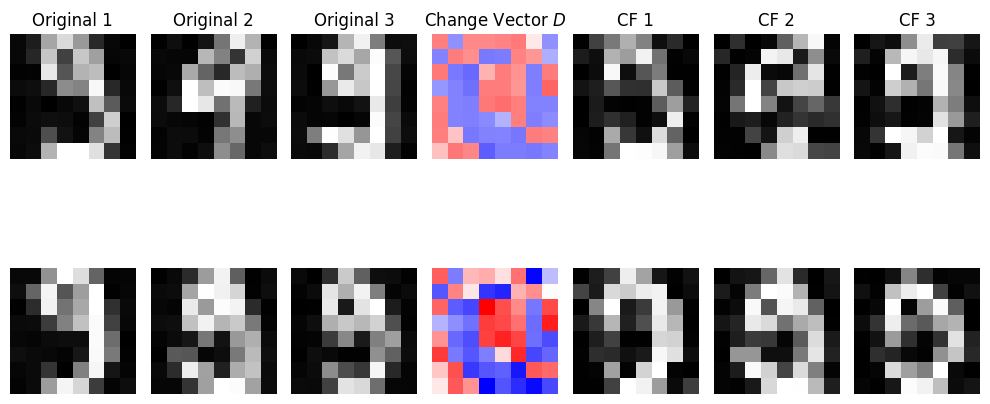

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming X_test_origin, Xs_cfs, D, and S are already defined
unique_groups = torch.unique(S.argmax(dim=1))
num_images = 3
fig, axes = plt.subplots(
    len(unique_groups), 2 * num_images + 1, figsize=(10, 6)
)  # 3 original, 1 D, 3 counterfactual

for group_i, group in enumerate(unique_groups):
    # Get indices for the current group
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    # num_images = min(3, len(group_indices))  # Limit to 3 images per group
    selected_indices = group_indices[:num_images]

    # Create a figure to display the images
    axes[group_i, num_images].imshow(
        D[group_i].reshape(8, 8).detach().numpy(), cmap="bwr_r", vmin=-1, vmax=1
    )
    if group_i == 0:
        axes[group_i, num_images].set_title(
            "Change Vector $D$", fontsize=12, fontfamily="sans-serif"
        )
    axes[group_i, num_images].axis("off")

    for i, idx in enumerate(selected_indices):
        # Original images on the left
        axes[group_i, i].imshow(
            DigitsDataset.inverse_transform(X_test_origin[idx].reshape(8, 8)),
            cmap="gray",
        )
        if group_i == 0:
            axes[group_i, i].set_title(
                f"Original {i + 1}", fontsize=12, fontfamily="sans-serif"
            )
        axes[group_i, i].axis("off")

        # Counterfactual images on the right
        axes[group_i, i + num_images + 1].imshow(
            DigitsDataset.inverse_transform(Xs_cfs[idx].reshape(8, 8)), cmap="gray"
        )
        if group_i == 0:
            axes[group_i, i + num_images + 1].set_title(
                f"CF {i + 1}", fontsize=12, fontfamily="sans-serif"
            )
        axes[group_i, i + num_images + 1].axis("off")

plt.tight_layout()
plt.savefig("digits_cf_90_no_plaus.pdf", dpi=300)
plt.show()

# 7 to 1 Transition

In [115]:
dataset = DigitsDataset("../data/digits.csv")
source_class = 7
target_class = 1
X_test_origin = dataset.X_test[np.argmax(dataset.y_test, axis=1) == source_class]
y_test_origin = dataset.y_test[np.argmax(dataset.y_test, axis=1) == source_class]

cf_method = PUMAL(
    X=X_test_origin,
    cf_method_type="GCE",
    K=3,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.01),
    not_actionable_features=None,
    neptune_run=None,
)

In [116]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    target_class=target_class,
    epochs=20000,
    lr=0.01,
    patience=500,
    alpha_dist=1e-3,
    alpha_plaus=0,
    alpha_class=10**5,
    alpha_s=10**3,
    alpha_k=0,
    log_prob_threshold=log_prob_threshold,
)

loss: 0.0001, dist: 0.1042, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000:  10%|█         | 2001/20000 [00:23<03:34, 84.03it/s]            


In [117]:
Xs_cfs = Xs + delta().detach().numpy()

M, S, D = delta.get_matrices()
print(S.sum(axis=0))
values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

y_pred = disc_model.predict(Xs_cfs).detach().numpy().flatten()
# print("Test accuracy:", (y_pred == ys_target).mean())
print("Test accuracy:", (y_pred == np.argmax(ys_target, axis=1)).mean())

tensor([ 0., 30., 83.], grad_fn=<SumBackward1>)
Correct: 113/113
2
Test accuracy: 1.0


In [118]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.01,
)

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 13.651593098658777,
 'proximity_continuous_manhattan': 104.15431625127923,
 'proximity_continuous_euclidean': 13.651593098658777,
 'proximity_continuous_mad': 115.75125587935996,
 'proximity_l2_jaccard': 13.651593098658777,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.0,
 'log_density_cf': -263.81937,
 'log_density_test': -105.06626,
 'lof_scores_cf': 1.4133278,
 'lof_scores_test': 1.0519035,
 'isolation_forest_scores_cf': 0.020369851635507336,
 'isolation_forest_scores_test': 0.0727471756127026}

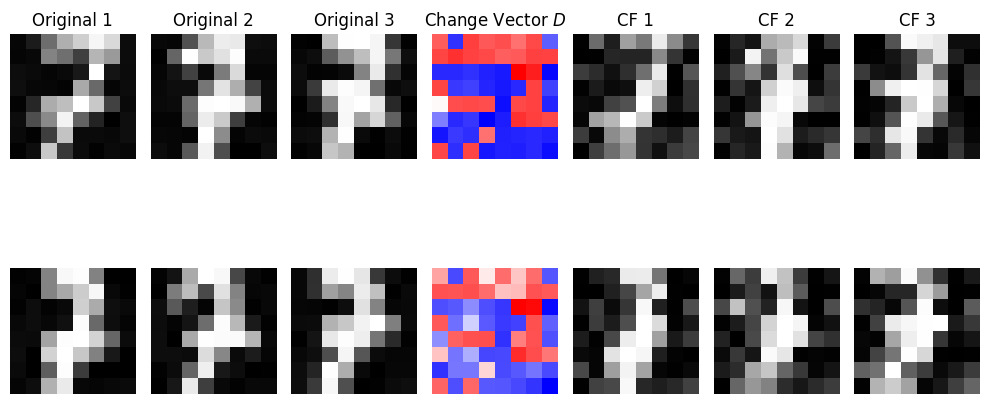

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming X_test_origin, Xs_cfs, D, and S are already defined
unique_groups = torch.unique(S.argmax(dim=1))
num_images = 3
fig, axes = plt.subplots(
    len(unique_groups), 2 * num_images + 1, figsize=(10, 6)
)  # 3 original, 1 D, 3 counterfactual

for group_i, group in enumerate(unique_groups):
    # Get indices for the current group
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    # num_images = min(3, len(group_indices))  # Limit to 3 images per group
    selected_indices = group_indices[:num_images]

    # Create a figure to display the images
    axes[group_i, num_images].imshow(
        D[group_i].reshape(8, 8).detach().numpy(),
        cmap="bwr_r",  # vmin=-1, vmax=1
    )
    if group_i == 0:
        axes[group_i, num_images].set_title(
            "Change Vector $D$", fontsize=12, fontfamily="sans-serif"
        )
    axes[group_i, num_images].axis("off")

    for i, idx in enumerate(selected_indices):
        # Original images on the left
        axes[group_i, i].imshow(
            DigitsDataset.inverse_transform(X_test_origin[idx].reshape(8, 8)),
            cmap="gray",
        )
        if group_i == 0:
            axes[group_i, i].set_title(
                f"Original {i + 1}", fontsize=12, fontfamily="sans-serif"
            )
        axes[group_i, i].axis("off")

        # Counterfactual images on the right
        axes[group_i, i + num_images + 1].imshow(
            DigitsDataset.inverse_transform(Xs_cfs[idx].reshape(8, 8)), cmap="gray"
        )
        if group_i == 0:
            axes[group_i, i + num_images + 1].set_title(
                f"CF {i + 1}", fontsize=12, fontfamily="sans-serif"
            )
        axes[group_i, i + num_images + 1].axis("off")

plt.tight_layout()
plt.savefig("digits_cf_71_no_plaus.pdf", dpi=300)
plt.show()